# Trabalho 2
Grupo 06
- Tomás Vaz de Carvalho Campinho A91668
- Miguel Ângelo Alves de Freitas A91635

In [ ]:
!pip install ortools

In [ ]:
import networkx as nx
import random
from ortools.linear_solver import pywraplp

Considere-se um circuit Booleano $C$ com $n$ "wires" de " input" e um único "wire" de output.


*   O circuito é descrito num bi-grafo com uma classe de nodos representando “gates” e a segunda classe representando “wires” . 
*   Cada nodo contém um campo val cujo conteúdo descreve a semântica desse nodo; para os “wires” o campo **val**  contém uma variável SCIP; para as “gates” o campo **val**  contém uma marca bo conjunto **and**, **or**,  **xor** e **not**,   que indica o tipo de “gate”.
*   Com exceção de not , que é um operador unário, todas as restantes “gates” têm um número arbitrário de “inputs” e um único “output”.
*   No grafo os arcos com origem numa determinada “gate”  têm destino nos “wires” que são “input” dessa “gate”. Cada “wire” que não é “input” é origem de um único arco que tem como destino a “gate” do qual esse “wire” é “output”.



1.   Escreva um programa que, a partir do número $n$ de "inputs" e de um parâmetro positivo γ≪1 como argumentos, gere aleatoriamente circuitos com "gates" **or**,**and** e **not** em que o número de **and**'s é γ * (número total de nodos).
2.   Escreva um programa Python que leia um circuito arbitrário descrito pelo bi-grafo anterior e formule as restrições (em Programação Inteira) que descrevem as várias “gates” do circuito.
3.   Usando os dois programas anteriores e o sistema SCIP, 
        1. Escreva um programa que determine um vetor de “inputs”   $,x\in\ {0,1}^n$ ,aceite pelo circuito (i.e. o respetivo output é $1$).
        2. Determine o vetor $x'\neq x$ , também aceite pelo circuito, que está mais próximo de $x$. 


1.   Escreva um programa que, a partir do número $n$ de "inputs" e de um parâmetro positivo γ≪1 como argumentos, gere aleatoriamente circuitos com "gates" **or**,**and** e **not** em que o número de **and**'s é γ * (número total de nodos).

In [ ]:
def geraInput(circuito,i,x,y,l):
  nodo=random.randint(x,y)
  while nodo==l:
    nodo=random.randint(x,y)

  circuito.add_edge(nodo,i)

  return nodo

def geraOutput(circuito,i,x,y,l):
  nodo=random.randint(x,y)
  while nodo in l:
    nodo=random.randint(x,y)

  l.append(nodo)
  circuito.add_edge(i,nodo)

  return nodo


def gera_circuito(N,Y):
    nGates = random.randint(N,N+2) #numero de gates total
    nAnds=round(Y*N) #numero de gates 'and'

    l=[]
    circuito = nx.DiGraph() 

    for i in range(N): #gerar inputs
      circuito.add_node(i,value='input')

    for i in range(nGates): #gerar outputs
      circuito.add_node(i+N,value='output') 
    
    for i in range(nGates-nAnds):  #gerar gates ('not', 'or', 'xor')
      tipogate = random.randint(1,3) # 1-not 2-or 3-xor
      if tipogate==1:
        circuito.add_node(i+N+nGates, value='not')
        output=geraOutput(circuito,i+N+nGates,N,N+nGates-1,l)
        input=geraInput(circuito,i+N+nGates,0,N+nGates-2,output)

      elif tipogate==2: 
        circuito.add_node(i+N+nGates, value='or') 
        output=geraOutput(circuito,i+N+nGates,N,N+nGates-1,l)
        input=geraInput(circuito,i+N+nGates,0,N+nGates-2,output)
        input=geraInput(circuito,i+N+nGates,0,N+nGates-2,input)

      elif tipogate==3:
        circuito.add_node(i+N+nGates, value='xor')  
        output=geraOutput(circuito,i+N+nGates,N,N+nGates-1,l)
        input=geraInput(circuito,i+N+nGates,0,N+nGates-2,output)
        input=geraInput(circuito,i+N+nGates,0,N+nGates-2,input)
          

    for i in range(nAnds): #gerar gates 'and'
        circuito.add_node(i+N+nGates-nAnds, value='and')
        output=geraOutput(circuito,i+N+nGates*2-nAnds,N,N+nGates-1,l)
        input=geraInput(circuito,i+N+nGates*2-nAnds,0,N+nGates-2,output)
        input=geraInput(circuito,i+N+nGates*2-nAnds,0,N+nGates-2,input)
      
    return circuito

#Definir restrições para o Solver(linguagem).

O problema consiste em 

$$x_{n} == 1  \quad \mbox{se e só se} \quad \mbox{o nodo $n$ tem valor lógico $true$}$$


Como  foi sendo indicado anteriormente, a descrição em LIA (“linear integer arithmetic”) de uma restrição construída com esta família de operadores é direta. No contexto do circuito o comportamento de uma gate é definido por ums restrição igualdade $y =\,\mathbf{op}(x_1,\cdots,x_n)$ sendo $y$ o “wire utput”  e $\,x_1,\cdots,x_n)\,$são os “wires” dos argumentos.


Quando se usam restrições inteiras, e um sistema como o SCIP, para descrever uma restrição booleana
$y =\,\mathbf{op}(x_1,\cdots,x_n)$ é necessário proceder à conversão dos operadores booleanos em relações inteiras.

O resultado final do circuito tem que ser igual **1** como referido a cima.


# Vamos ter 4 tipos de retrições:

1. Gate é do tipo "AND". Logo

$$(\sum_i x_i < y+n)      \wedge      (x_i \geq y)   ;    \quad      \forall i=1..n$$

2. Gate é do tipo "NOT". logo
$$y + x = 1$$

3. Gate é do tipo "OR". logo
$$(y \leq \sum_i\,x_i\quad)      \wedge        x_i \leq y\ \quad        \forall i=1..n$$

4. Gate é do tipo "XOR". 

​$$y + 2y' = \sum_{i=1}^n$$

$y'$ é uma nova variável  tal que $\,0\leq y' \leq \lfloor n/2\rfloor$

Com estas 4 restrições no solver vamos **maximizar** a soma dos inputs.




In [ ]:
def resolver_circuito(graph, N):
  
    solver = pywraplp.Solver.CreateSolver('SCIP')
    o = 0
    for n in nx.to_dict_of_lists(graph):
        if (nx.to_dict_of_lists(graph)[n]) == []:
            o = n
    x = {}
    y = {}
    for n in graph:
        if (n != o):
            if (graph.nodes[n]['value'] == 'input' or graph.nodes[n]['value'] == 'output'):
                x[n] = solver.BoolVar(str(n))       
        else:
            x[n] = solver.BoolVar(str(n))
            solver.Add(x[n] == 1)

    for n in graph:
        

        if graph.nodes[n]['value'] == 'not':
            s = list(graph.out_edges(n))[0]
            t = list(graph.in_edges(n))
            solver.Add(x[s[1]] + x[t[0][0]] == 1)  
      
        if graph.nodes[n]['value'] == 'or':
            s = list(graph.out_edges(n))[0]
            t = list(graph.in_edges(n))
            solver.Add(x[s[1]] <= sum(x[sx] for sx, sy in t))
            for sx, sy in t:
                solver.Add(x[sx] <= x[s[1]])
                
        if graph.nodes[n]['value'] == 'and':
            s = list(graph.out_edges(n))[0]
            t = list(graph.in_edges(n))
            solver.Add(sum(x[sx] for sx, sy in t) <= x[s[1]] + len(t) - 1)
            for sx, sy in t:
                solver.Add(x[sx] >= x[s[1]])

        if graph.nodes[n]['value'] == 'xor':
            s = list(graph.out_edges(n))[0]
            t = list(graph.in_edges(n))
            y[n] = solver.BoolVar(str(n))
            solver.Add(0 <= y[n] <= len(t) / 2)
            solver.Add(x[s[1]] + y[n] * 2 == sum(x[sx] for sx, xy in t))

    solver.Maximize(sum(x[i] for i in range(N)))
    assert(solver.Solve()==pywraplp.Solver.OPTIMAL)

    resultado=[graph.nodes[i]['value'] for i in range(N)]

    if solver.NextSolution():
      print("Mais próximo: "+str([round(x[i].solution_value()) for i in range(N)]) )
    else:
      print("Não foi encontrado outro vetor")


Exemplos:

Mais próximo: [1, 0, 0]


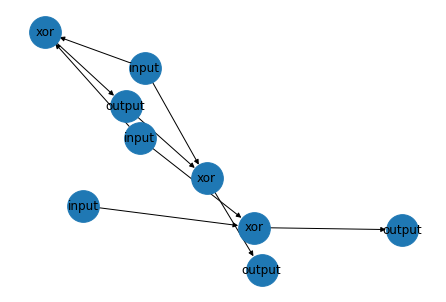

In [ ]:
#número de inputs
N=3
Y=0.1

circuito = gera_circuito(N,Y)
resolver_circuito(circuito, N)    

nx.draw(circuito, with_labels=True, labels = {x:(circuito.nodes[x]['value']) for x in circuito}, node_size=1003)

Mais próximo: [1, 0]


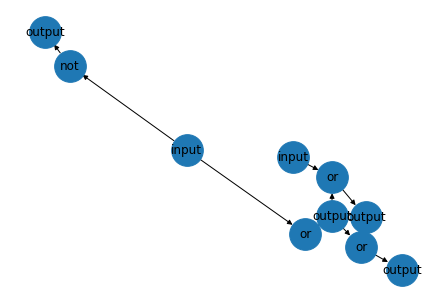

In [ ]:
#número de inputs
N=2
Y=0.2

circuito = gera_circuito(N,Y)
resolver_circuito(circuito, N)    

nx.draw(circuito, with_labels=True, labels = {x:(circuito.nodes[x]['value']) for x in circuito}, node_size=1003) 